# Punto 1

In [1]:
import os
import pandas as pd
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#llamar datos de la carpeta data; dirBase, ciudad &origenData =Str 

def llamarDatos(ciudad, origenData):
    serie=os.path.join('.','data',ciudad,origenData+'.csv')
    serie_pd = pd.read_csv(serie, sep = ';',encoding='latin-1')
    return serie_pd

ciudades: Barranquilla, Cali,
          Carmendebolivar, Medellin,
          SantaMarta, Sucre, Uribia, Valledupar
          
origenesData: IDEAM, NREL

In [3]:
#Calcular la energía total al mes
def ghiMensual(serie):
    agnos=sorted (serie['AÑO'].unique()) #sorted() organiza los datos de menor a mayot
    nombre_energia = list(serie)[-1] #list [x](i) toma el primer valor de la columna i del dataFrame X
    DefinitiveDataFrame =pd.DataFrame(columns=["AÑO","MES","DIAS","GHIMensual","GHIdiarioPromedio"+nombre_energia]) #Construyo el nuevo DataFrame
    for agno in agnos:
        for mes in range (1,13): #range() no toma el último valor
            dias=sorted(serie[(serie['AÑO']==agno)&(serie['MES']==mes)]['DIA'].unique()) #tomo el número de dias por mes
            ghiMensual=serie.loc[((serie['AÑO']==agno)&(serie['MES']==mes)),nombre_energia].sum()/1000 #calculo la suma de la energia mensual en kWh
            #serie.loc[cond,'x'] me toma los valores de la columna 'x' de un dataframe dada una condicion
            ghiDiario=ghiMensual/dias[-1] #Calculo del valor diario promedio mensual            
            ghi=dict([("AÑO",agno),("MES",mes),("DIAS",dias[-1]),("GHIMensual",ghiMensual),("GHIdiarioPromedio"+nombre_energia,ghiDiario)]) #retorna una lista: {Mes:x,DIAS:y,etc}
            DefinitiveDataFrame=DefinitiveDataFrame.append(ghi, ignore_index=True) #Guardo mis datos en el DataFrame ignore_index ignora los labels de los datos
    return DefinitiveDataFrame

In [4]:
def enficc(serie):
    percentil=0.01
    en= ghiMensual(serie).quantile(q=percentil,numeric_only=True)["GHIdiarioPromedio"+list(serie)[-1]]
    return 'La ENFICC 99% es ',en

In [16]:
serie=llamarDatos("Barranquilla","IDEAM")
enficc(serie)[1]

4.1605902581736194

# Punto 2

In [6]:
def graficar(ciudad1,ciudad2,ciudad3,ciudad4,origenData):
    serie1=llamarDatos(ciudad1,origenData)
    serie2=llamarDatos(ciudad2,origenData)
    serie3=llamarDatos(ciudad3,origenData)
    serie4=llamarDatos(ciudad4,origenData)
    data1=sorted(ghiMensual(serie1)["GHIdiarioPromedio"+list(serie1)[-1]])
    data2=sorted(ghiMensual(serie2)["GHIdiarioPromedio"+list(serie2)[-1]])
    data3=sorted(ghiMensual(serie3)["GHIdiarioPromedio"+list(serie3)[-1]])
    data4=sorted(ghiMensual(serie4)["GHIdiarioPromedio"+list(serie3)[-1]])
    numdatos1=range(len(data1))
    numdatos2=range(len(data2))
    numdatos3=range(len(data3))
    numdatos4=range(len(data4))
    fig=figure()
    pylab.xlabel("Datos")
    pylab.ylabel("Energía/Energía Base")
    pylab.title(origenData)
    pylab.plot(numdatos1,data1/data1[0],'-k', label=ciudad1)
    pylab.plot(numdatos2,data2/data2[0],'-y', label=ciudad2)
    pylab.plot(numdatos3,data3/data3[0],'-r', label=ciudad3)
    pylab.plot(numdatos4,data4/data4[0],'-b', label=ciudad4)
    pylab.legend(loc='upper left')
    return

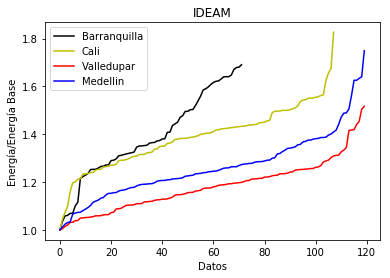

In [7]:
graficar('Barranquilla','Cali','Valledupar','Medellin','IDEAM')

# Punto 3

In [8]:
#OJO, datos satelitales son NREL, datos reales son IDEAM
#Seleccionar pedazos de series

#serieObj tiene como entrada el año inicial, el mes inicial, el año final, el mes final y la ciudad del trozo de la serie de datos medidos NREL con lo cuales se corregirá
#Su salida es un DataFrame conteniendo el trozo de datos medidos en sitio "NREL" a corregir
def serieObj (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    origen='IDEAM'
    x=llamarDatos(ciudad,origen)[(llamarDatos(ciudad,origen)['AÑO']>=agnoInicial)&
                               (llamarDatos(ciudad,origen)['MES']>=mesInicial)&
                               (llamarDatos(ciudad,origen)['AÑO']<=agnoFinal)&
                               (llamarDatos(ciudad,origen)['MES']<=mesFinal)]
    return x
#serieRef tiene como entrada el año inicial, el mes inicial, el año final, el mes final y la ciudad del trozo de la serie de datos medidos NREL con lo cuales se corregirá
#Su salida es un DataFrame conteniendo el trozo de datos satelitales "IDEAM" en la misma temporalidad que el trozo de NREL con lo cuales se corregirá
def serieRef (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    origen='NREL'
    y=llamarDatos(ciudad,origen)[(llamarDatos(ciudad,origen)['AÑO']>=agnoInicial)&
                               (llamarDatos(ciudad,origen)['MES']>=mesInicial)&
                               (llamarDatos(ciudad,origen)['AÑO']<=agnoFinal)&
                               (llamarDatos(ciudad,origen)['MES']<=mesFinal)]
    return y
#MCP tiene como entrada el año inicial, el mes inicial, el año final, el mes final y la ciudad del trozo de la serie de datos medidos NREL con lo cuales se corregirá
#Su salida es un dataframe con Año, Mes, Dia, Datos satelitales "IDEAM" y Datos corregidos "MCP" en temporalidad horaria de 10 años
def MCP (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    #Parámetros para calcular MCP
    origenRef='NREL'
    origenObj='IDEAM'
    Ref=serieRef (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)[origenRef]
    Obj=serieObj (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)[origenObj]
    GHImean_Ref=Ref.sum()/count_nonzero(Ref)
    GHImean_Obj=Obj.sum()/count_nonzero(Obj)
    DSTD_Ref=Ref[Ref!=0].std()
    DSTD_Obj=Obj[Obj!=0].std()
    relDSTDs=DSTD_Obj/DSTD_Ref
    #corrección
    refLarga=llamarDatos(ciudad,origenRef)[origenRef]
    A=GHImean_Obj-(relDSTDs*GHImean_Ref)
    B=relDSTDs*refLarga
    df=llamarDatos(ciudad,origenRef)
    df['IDEAM']=llamarDatos(ciudad,origenObj)[origenObj]
    df['MCP']=A+B
    return df
#Cortar Serie
def cortarSerie(serie,agnoInicial,agnoFinal):
    x=serie[(serie['AÑO']>=agnoInicial)&
            (serie['AÑO']<=agnoFinal)]
    return x
#plotPorCiudad tiene como entrada el año inicial, el mes inicial, el año final, el mes final y la ciudad del trozo de la serie de datos medidos NREL con lo cuales se corregirá
#Su salida es una gráfica con los promedios mensuales en temporalidad mensual de 10 años
def plotPorCiudad (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    origenRef='NREL'
    origenMed='IDEAM'
    MCPData=ghiMensual(MCP(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad))['GHIMensual']
    NREL=ghiMensual(llamarDatos(ciudad,origenRef))['GHIMensual']
    IDEAM=ghiMensual(llamarDatos(ciudad,origenMed))['GHIMensual']
    #Corregida=cortarSerie(MCPData,IDEAM['AÑO'].min(),IDEAM['AÑO'].max())['GHIMensual']
    #Satelitales=cortarSerie(NREL,IDEAM['AÑO'].min(),IDEAM['AÑO'].max())['GHIMensual']
    #Medidos=IDEAM['GHIMensual']
    #
    fig=figure()
    pylab.xlabel('Meses')
    pylab.ylabel(r'$GHI[\frac{W}{m^2}]$')
    pylab.plot(range(len(NREL)),NREL,'-k', label='Datos Satelitales')
    pylab.plot(range(len(IDEAM)),IDEAM,'-b', label='Datos Medidos')
    pylab.plot(range(len(MCPData)),MCPData,'-r', label='Datos Corregidos')
    pylab.legend(loc='upper left')
    #
    fig1=figure()
    pylab.xlabel("Datos")
    pylab.ylabel("Energía/Energía Base")
    MCP2=sorted(MCPData)
    NREL2=sorted(NREL)
    IDEAM2=sorted(IDEAM)
    pylab.xlabel('Datos')
    pylab.ylabel(r'$GHI/GHI[\frac{W}{m^2}]/[\frac{W}{m^2}]$')
    pylab.plot(range(len(NREL2)),NREL2/NREL2[0],'-k', label='Datos Satelitales')
    pylab.plot(range(len(IDEAM)),IDEAM2/IDEAM2[0],'*b', label='Datos Medidos')
    pylab.plot(range(len(MCPData)),MCP2/MCP2[0],'-r', label='Datos Corregidos')
    pylab.legend(loc='upper left')
    return fig1,'CUIDADO: La serie de datos medidos inicia en el año ',serieObj (agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)['AÑO'].min() 

(<matplotlib.figure.Figure at 0x7f2021bcab70>,
 'CUIDADO: La serie de datos medidos inicia en el año ',
 2010)

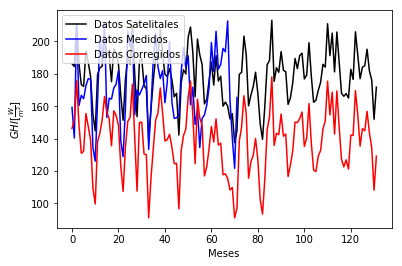

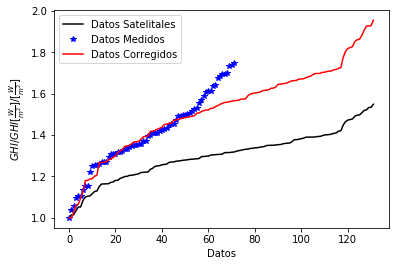

In [9]:
plotPorCiudad(2010,1,2015,1,"Barranquilla")

# Punto 4

In [10]:

#Error RMS
def RMS(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    modMCP='MCP'
    modNREL='NREL'
    obs='IDEAM'
    #
    XmodMCP=MCP(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)[modMCP]
    XmodNREL=MCP(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)[modNREL]
    Xobs=MCP(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)[obs]
    #       
    RMSMCPinsideSum=(Xobs-XmodMCP)**2
    RMSNRELinsideSum=(Xobs-XmodNREL)**2
    #
    RMSMCP=((RMSMCPinsideSum.sum()/len(RMSMCPinsideSum))**0.5)/(Xobs.max()-Xobs.min())
    RMSNREL=((RMSNRELinsideSum.sum()/len(RMSNRELinsideSum))**0.5)/(Xobs.max()-Xobs.min())
    #
    df=pd.DataFrame({'RMS':[0,RMSNREL,RMSMCP]},index=['ideal','NREL vs IDEAM','MCP vs IDEAM'])
    return df
def MBE(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    modMCP='MCP'
    modNREL='NREL'
    obs='IDEAM'
    #
    XmodMCP=MCP(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)[modMCP]
    XmodNREL=MCP(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)[modNREL]
    Xobs=MCP(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)[obs]
    #
    ErrMBEMCP=(XmodMCP-Xobs).sum()/(Xobs.sum())
    ErrMBENREL=(XmodNREL-Xobs).sum()/(Xobs.sum())
    #
    df=pd.DataFrame({'MBE':[0,ErrMBENREL,ErrMBEMCP]},index=['ideal','NREL vs IDEAM','MCP vs IDEAM'])
    return df
#Error KSI
def KSI(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    agno1=llamarDatos(ciudad,'IDEAM')['AÑO'].min()
    agno2=llamarDatos(ciudad,'IDEAM')['AÑO'].max()    
    NREL=cortarSerie(llamarDatos(ciudad,'NREL'),agno1,agno2)['NREL']
    DataMCP=cortarSerie(MCP(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad),agno1,agno2)['MCP']
    #NREL=llamarDatos(ciudad,'NREL')['NREL']
    #DataMCP=MCP(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)
    IDEAM=llamarDatos(ciudad,'IDEAM')['IDEAM']    
    ErNREL=stats.ks_2samp(NREL,IDEAM)
    ErMCP=stats.ks_2samp(DataMCP,IDEAM)
    df=pd.DataFrame({'D':[0,ErNREL[0],ErMCP[0]],'p-Value':[1,ErNREL[1],ErMCP[1]]},index=['ideal','NREL vs IDEAM','MCP vs IDEAM'])
    return df

In [21]:
def errores(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    df=RMS(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)
    df['MBE']=MBE(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)['MBE']
    df['KS statistic']=KSI(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)['D']
    df['p-Value']=KSI(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad)['p-Value']
    return df
def enficcs(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad):
    enIDEAM=enficc(llamarDatos(ciudad,'IDEAM'))
    enNREL=enficc(llamarDatos(ciudad,'NREL'))
    enMCP=enficc(MCP(agnoInicial,mesInicial,agnoFinal,mesFinal,ciudad))
    df=pd.DataFrame({'IDEAM':[enIDEAM[1]],'NREL':[enNREL[1]],'MCP':[enMCP[1]]},index=['ENFICC'])
    return df

In [22]:
errores(2007,1,2015,1,"Valledupar")
enficcs(2007,1,2015,1,"Valledupar")

,IDEAM,MCP,NREL
ENFICC,4.569007,4.291466,5.062653


# Punto 5 (Análisis)

Como se expone en el enunciado de este taller, la ENFICC es la Energía en Firme para el Cargo por Confiabilidad para plantas de generación eléctrica, en este caso específico se tendrán en cuenta sólo las plantas fotovoltáicas y se calculará teniendo en cuenta 2 series de datos de radiación solar: Una serie tomada por mediciones satelitales realizadas por la National Renewable Energy Laboratory por un periodo de 2005-2015 y una serie de datos medidos en sitio por el IDEAM para cada uno de los lugares a evaluar (Barranquilla, Cali, Carmendebolivar, Medellin, SantaMarta, Sucre, Uribia, Valledupar).
Entonces, el objetivo de este taller busca analizar el procedimiento por relación de varianzas que se realizó para ajustar los datos satelitales a los datos medidos en sitio.

Inicialmente, se mostrará el comportamiento de cada uno de las series (NREL e IDEAM) para cada una de las ciudades para comentar acerca de estas y entender que es lo que se requiere realizar para acoplar correctamente las gráficas

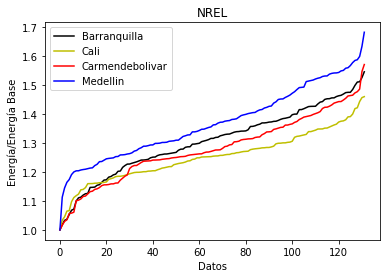

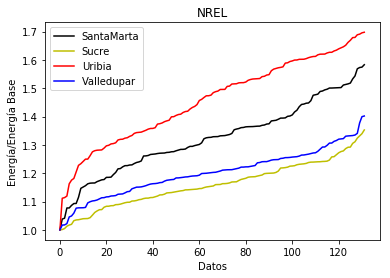

In [14]:
graficar('Barranquilla','Cali','Carmendebolivar','Medellin','NREL')
graficar('SantaMarta','Sucre','Uribia','Valledupar','NREL')

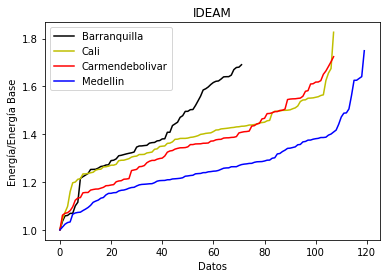

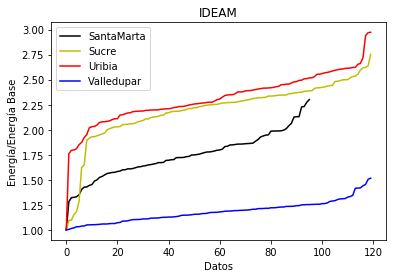

In [15]:
graficar('Barranquilla','Cali','Carmendebolivar','Medellin','IDEAM')
graficar('SantaMarta','Sucre','Uribia','Valledupar','IDEAM')

Es posible observar que el comportamiento de los datos medidos en sitio tienen una notable diferencia en la mayoría de ciudades, entonces, como se propuso en el protocolo presentado, se ajustarán inicialmente los datos teniendo en cuenta temporalidades de 1 año para los datos medidos. Debido a cuestiones de extensión se presentará en este caso solo para los años más caliente (2010) y más frío (2008) de los ultimos 13 años en donde las temperaturas medias anuales fueron respectivamente, 14.53°C y 14.36°C: